In [1]:
"""
adiabatic kinetics simulation with sensitivity analysis
"""
import sys
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt
import timeit

def ign_uq(g, factor, temp, pres, fuel, phi, T_equi, simtype='UV', bootplot=False):
	gas.set_multiplier(1.0) # reset all multipliers
	for i in range(gas.n_reactions):
		gas.set_multiplier(factor[i],i)
		# print(gas.reaction_equation(i)+' index_reaction:',i,'multi_factor:',factor[i])
	
	gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
	gas.TP = temp, pres*ct.one_atm

	# here it is constant volume with IdealGasReactor
	if simtype == 'UV':
		r = ct.IdealGasReactor(gas)
	else:
		r = ct.IdealGasConstPressureReactor(gas)

	sim = ct.ReactorNet([r])
	
	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15

	t_end = 10;
	time = []
	temp = []
	states = ct.SolutionArray(gas, extra=['t'])

	# stateArray = []
	while sim.time < t_end and r.T < T_equi - 0.1:
		sim.step()
		time.append(sim.time)
		temp.append(r.T)
		states.append(r.thermo.state, t=sim.time)
		# stateArray.append(r.thermo.X)

	time = np.array(time)
	temp = np.array(temp)
	diff_temp = np.diff(temp)/np.diff(time)

	if 0:
		# print(r.T, T_equi)
		plt.figure()
		plt.plot(states.t, states.T, '-ok')

		# plt.plot( 1.0, states.T[ign_pos], 'rs',markersize=6  )
		plt.xlabel('Time [ms]')
		plt.ylabel('T [K]')
		# plt.xlim( 0.99, 1.01 )
		#plt.ylim( -0.001,0.001 )
		plt.tight_layout()
		plt.show()

	ign_pos = np.argmax( diff_temp )

	ign = time[ign_pos]
	
	gas.set_multiplier(1.0) # reset all multipliers

	return ign

def ign_sens(g, temp, pres, fuel, phi, ign0, simtype='UV', bootplot=False):
	'''
	ign_sens(g, temp, pres, fuel, phi, ign0, simtype='UV', bootplot=False)
	'''
	gas.set_multiplier(1.0) # reset all multipliers

	gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
	gas.TP = temp, pres*ct.one_atm

	# here it is constant volume with IdealGasReactor
	if simtype == 'UV':
		r = ct.IdealGasReactor(gas)
	else:
		r = ct.IdealGasConstPressureReactor(gas)

	sim = ct.ReactorNet([r])
	for i in range(gas.n_reactions):
		r.add_sensitivity_reaction(i)

	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15
	sim.rtol_sensitivity = 1.0e-6
	sim.atol_sensitivity = 1.0e-6
	sens_T = []
	states = ct.SolutionArray(gas, extra=['t'])

	t_end = 10;
	time = []
	temp = []
	# stateArray = []
	while sim.time < ign0*1.5:
		sim.step()
		sens_T.append( sim.sensitivities()[2,:] )
		states.append(r.thermo.state, t=sim.time)
		time.append( sim.time )
		temp.append( r.T )

	time = np.array(time)
	temp = np.array(temp)
	diff_temp = np.diff(temp)/np.diff(time)
	sens_T = np.array( sens_T )

	ign_pos = np.argmax( diff_temp )
	ign = time[ign_pos]
	
	if bootplot:
		plt.figure()
		plt.plot(states.t/ign0, states.T, '-ok')

		plt.plot( 1.0, states.T[ign_pos], 'rs',markersize=6  )
		plt.xlabel('Time [ms]')
		plt.ylabel('T [K]')
		plt.xlim( 0.99, 1.01 )
		#plt.ylim( -0.001,0.001 )
		plt.tight_layout()
		plt.show()

	sens_T_ign = sens_T[ign_pos, :]
	return sens_T_ign

pres = 20
temp = 1000.0
phi = .5
simtype = 'UV'

fuel = 'CH4'
mech = 'gri30.xml'
dk = 5.e-2

# mech = 'h2_li_19.xml'
# fuel = 'nc7h16'
# mech = 'nc7sk88.cti'
# gas = ct.Solution('mech/dme_sk39.cti')
# gas = ct.Solution('mech/ic8sk143.cti')
# mech = "c4_49.xml"

string_list = [fuel, mech, str(phi), str(pres), str(temp), str(dk), simtype]
string_list = '_'.join(string_list)
print(string_list)


mechfile = 'mech/'+mech
gas = ct.Solution(mechfile)
gas.set_equivalence_ratio( phi, fuel, 'O2:1.0, N2:3.76' )
gas.TP = temp, pres*ct.one_atm

print('species_names:')
# print(gas.species_names)
# print(gas.species_index('OH'))

# Get equilibrium temperature for ignition break
gas.equilibrate(simtype)
T_equi = gas.T

m = gas.n_reactions

# Create a dataframe to store sensitivity-analysis data
ds = pd.DataFrame(data=[], index=gas.reaction_equations(range(m)))
pd.options.display.float_format = '{:,.2e}'.format

# Create an empty column to store the sensitivities data. 
# baseCase for brute force method
ds["index"] = ""
ds["bruteforce"] = ""
ds["adjoint"] = ""
ds["ratio"] = ""

# base case
factor = np.ones( gas.n_reactions )
ign0 = ign_uq(gas, factor, temp, pres, fuel, phi, T_equi, simtype, False)
print("Ignition Delay is: {:.4f} ms".format(ign0*1000))


start_time = timeit.default_timer()
print('Start Adjoint')

sens_T_ign = ign_sens(gas, temp, pres, fuel, phi, ign0, simtype, False)

elapsed = timeit.default_timer() - start_time
print('Finish Adjoint {:.2f}'.format(elapsed))


factor = np.ones( ( gas.n_reactions, 1 ) )

start_time = timeit.default_timer()
print('Start Brute Force')

for i in range(m):
    factor[i] = 1+dk
    ign = ign_uq(gas, factor, temp, pres, fuel, phi, T_equi, simtype, False)
    factor[i] = 1.0
    ds["bruteforce"][i] = (ign-ign0)/(ign0*dk)

elapsed = timeit.default_timer() - start_time
print('Finish Brute Force {:.2f}'.format(elapsed))




for i in range(m):
    ds['index'][i] = i
    ds["adjoint"][i] = -sens_T_ign[i]
    ds["ratio"][i] = ds["bruteforce"][i] /(ds["adjoint"][i] + 1.E-30)

ds['adjointabs'] = ds['adjoint'].abs()
ds = ds.sort_values( by=["adjointabs"] ,ascending=False)
# print( ds.to_string(index=True) )


index = ds['adjoint'].abs() > 0.05*ds['adjoint'].abs().max()
rxn1 = sum(index)
error1 = (ds[index]['ratio'].max() - ds[index]['ratio'].min())/ds[index]['ratio'].max()*100
print( sum(index) ,error1 )

index = ds['adjoint'].abs() > 0.01*ds['adjoint'].abs().max()
rxn2 = sum(index)
error2 = (ds[index]['ratio'].max() - ds[index]['ratio'].min())/ds[index]['ratio'].max()*100
print( sum(index) ,error2 )

ubf = ds['bruteforce']/np.linalg.norm(ds['bruteforce'])
uad = ds['adjoint']/np.linalg.norm(ds['adjoint'])
results_df = pd.DataFrame(data = {"maxerror_0.1":[error1, rxn1],"maxerror_0.01":[error2, rxn2], "ign0|cos":[ign0, np.dot(ubf.values, uad.values)]})


CH4_gri30.xml_0.5_20_1000.0_0.05_UV
species_names:
Ignition Delay is: 34.8857 ms
Start Adjoint
Finish Adjoint 58.35
Start Brute Force
Finish Brute Force 50.46
14 4.3726681931
22 11.5521273449


<IPython.core.display.Javascript object>


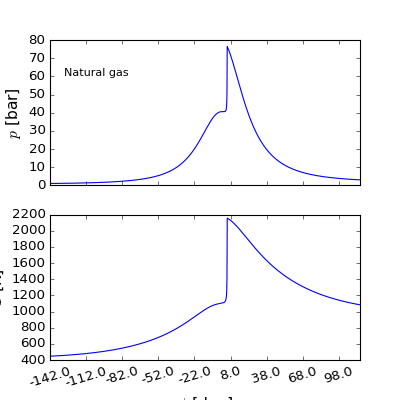

id_crank [degree]     5.1613 p_max [atm]    75.3863 T_max [K]  2155.2125


In [8]:
#######################################################################
# Input Parameters
#######################################################################

f = 1000. / 60.  # engine speed [1/s] (1000 rpm)
CR = 16.5  # compression ratio [-]
D = 12.065 /100.  # piston diameter [m]
LOLR = 3.714286

# set up IC engine parameters
A_piston = .25 * np.pi * D ** 2
stroke = 0.14005 # [m]
V_H = A_piston*stroke#displaced volume [m**3]
V_oT = V_H / (CR - 1.)

# simulation starts from intake valve close
inlet_close = -142. / 180. * np.pi
sim_end = 115. /180. * np.pi

# turbocharger temperature, pressure, and composition
T_inlet = 447.  # K
p_inlet = 1.065*ct.one_atm  # [pa]
# comp_inlet = 'C2H6:0.02679, C3H8:0.01767, CH4:0.51927, CO2:0.48316, H2O:0.90343, N2:10.174899, O2:2.705275'
comp_inlet = 'CH4:0.0350,C2H6:0.0018,C3H8:0.0012,O2:0.1824,CO2:0.0326,H2O:0.0609,N2:0.6861';

# Reaction mechanism name
reaction_mechanism = 'mech/gri30.xml'

# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet

r = ct.IdealGasReactor(gas)
ambient_air = ct.Reservoir(gas)

# define piston
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
#     return np.remainder(2 * np.pi * f * t + inlet_close, 4 * np.pi)
    return 2. * np.pi * f * t + inlet_close

def crank2t(theta):
    return ( theta / 180. * np.pi - inlet_close )/ 2./ np.pi /f

def volume(t):
    theta = crank_angle(t)
    return V_oT*(1+(CR-1)/2.*(LOLR+1-np.cos(theta)-np.sqrt(LOLR**2-np.sin(theta)**2)))

def piston_speed(t):
#     return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
    Omega = 2 * np.pi * f
    theta = crank_angle(t)
    dVdt = V_oT*Omega*(CR-1)/2.*np.sin(theta)*(1. + np.cos(theta)/np.sqrt(LOLR**2 - np.sin(theta)**2))
    return -dVdt / A_piston

r.volume = volume(0)
piston.area = A_piston
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])
# sim.set_max_time_step(1e-6)

for i in range(gas.n_reactions):
		r.add_sensitivity_reaction(i)

# set up output data arrays
states = ct.SolutionArray(r.thermo)
t = []
vol = []
sens_T = []

# From IVC to the end of the simulation
# print('%10s %10s %10s %10s %10s %10s %14s' % ('t [s]','crank','piston u','volume','T [K]','P [Pa]','u [J/kg]'))
while crank_angle(sim.time) < sim_end:
    sim.step()
    sens_T.append( sim.sensitivities()[2,:] )
    states.append(r.thermo.state)
    t.append(sim.time)
    vol.append(r.volume*1E6) #cm^3
#     print('%10.3e %10.1f %10.3e %10.3e %10.3f %10.3f %14.6e' % (sim.time, crank_angle(sim.time)*180/np.pi, piston_speed(sim.time),r.volume, r.T,
#                                            r.thermo.P, r.thermo.u))

t = np.array(t)
crank = np.array(crank_angle(t)* 180. / np.pi)
diff_temp = np.divide(np.diff(states.T), np.diff(t))

id_index = np.argmax( diff_temp )
id_crank = crank[id_index]
id_time = t[id_index]
p_max = np.max(states.P) / ct.one_atm
T_max = np.max(states.T)

#####################################################################
# Plot Results in matplotlib
#####################################################################
if 1:
    import matplotlib.pyplot as plt
    %matplotlib notebook

    # pressure and temperature
    plt.figure(figsize=(5,5))
    plt.clf()
    plt.clf()
    plt.subplot(211)
    plt.plot(t, states.P / 1.e5)
    plt.ylabel('$p$ [bar]',fontsize=14)
    # plt.xlabel('$\phi$ [deg]')
    # plt.xlim( (crank2t(-30), crank2t(30)) )
    plt.text(crank2t(-130), 60, r'Natural gas', fontsize=10)
    plt.xticks(plt.xticks()[0], [])
    plt.xlim((np.min(t), np.max(t)))
    plt.tick_params(which='both', direction='in')

    plt.subplot(212)
    plt.plot(t, states.T)
    plt.ylabel('$T$ [K]', fontsize=14)
    plt.xlabel('$\phi$ [deg]', fontsize=14)
    plt.xticks()
    # plt.xlim( (crank2t(-30), crank2t(30)) )
    plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180 / np.pi,
               rotation=17)
    plt.xlim((np.min(t), np.max(t)))
    plt.tick_params(which='both', direction='in')
    figname = 'figs/NG_P_T_Full.tiff'
    #plt.savefig(figname, dpi=220, bbox_inches='tight', pad_inches=0.1  )
    plt.show()

print('id_crank [degree] {:10.4f} p_max [atm] {:10.4f} T_max [K] {:10.4f}'.format(id_crank, p_max, T_max)  )
out = np.hstack((np.array([id_crank, id_time, p_max, T_max]) ,states.X[-1,:] ))
#print(out)

In [9]:
gas.n_species

53